In [142]:
#Importando as bibliotecas
import cv2
import matplotlib.pyplot as plt
import matplotlib
import random
from random import randint

import numpy as np

matplotlib.style.use('dark_background')
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)
matplotlib.rcParams['image.cmap'] = 'gray'
#%matplotlib inline

DATA_PATH = r"D:\Estudos\OpenCV\Computer Vision - Introduction\w9 - Video Analysis\data"

In [143]:
def maxRectArea(rects):
    area = 0
    maxRect = rects[0].copy()

    for rect in rects:
        x, y, w, h = rect.ravel()
        if w*h > area:
            area = w*h
            maxrect = rect.copy()

    maxRect = maxRect[:, np.newaxis]

    return maxRect

In [144]:
winSize = (64,128)
blockSize = (16,16)
blockStride = (8,8)
cellSize = (8,8)
nbins = 9
derivAperture = 1
winSigma = -1
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = True
nlevels = 64
signedGradient = False

In [145]:
hog = cv2.HOGDescriptor(
    winSize, blockSize, blockStride,
    cellSize, nbins, derivAperture, winSigma,
    histogramNormType, L2HysThreshold,
    gammaCorrection, nlevels, signedGradient
)

In [146]:
svmDetector = cv2.HOGDescriptor_getDefaultPeopleDetector()
hog.setSVMDetector(svmDetector)

In [147]:
cap = cv2.VideoCapture(DATA_PATH + "\\videos\\soccer.mp4")

# Confirm video is open
if not cap.isOpened():
    print("Unable to read video")

In [148]:
# Variable for storing frames
frameDisplay = []

blue = (255, 0, 0)
red = (0, 0, 255)

In [149]:
KF = cv2.KalmanFilter(6, 3, 0)

In [150]:
KF.transitionMatrix = cv2.setIdentity(KF.transitionMatrix )

In [151]:
print(KF.transitionMatrix )

[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]


In [152]:
KF.measurementMatrix = cv2.setIdentity(KF.measurementMatrix)

In [153]:
print(KF.measurementMatrix)

[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]


In [154]:
measurement = np.zeros((3,1), dtype = np.float32)
objectTracked = np.zeros((4,1), dtype = np.float32)
objectDetected = np.zeros((4,1), dtype = np.float32)

In [155]:
updatedMeasurement = np.zeros((3,1), dtype=np.float32)
predictedMeasurement = np.zeros((6,1), dtype=np.float32)

In [156]:
measurementWasUpdated = False
ticks = 0
preTicks = 0

## Read Frames and detect objects

In [157]:
sucess = True

while sucess:

    sucess, frame = cap.read()
    objects, weights = hog.detectMultiScale(frame, winStride=(8, 8), padding=(3, 3),
                                            scale=1.05, hitThreshold=0, useMeanshiftGrouping=False)
    ticks = cv2.getTickCount()
    print(objects)

    if len(objects) > 0:

        objectDetected = maxRectArea(objects)
        measurement = objectDetected[:3].astype(np.float32)

        KF.statePost[0:3, 0] = measurement[:, 0]
        KF.statePost[3:6] = 0.0

        KF.processNoiseCov  = cv2.setIdentity(KF.processNoiseCov , (1e-2))
        KF.measurementNoiseCov = cv2.setIdentity(KF.measurementNoiseCov, (1e-2))
        break

[[275  66  92 185]]


## Apply Kalma Filter

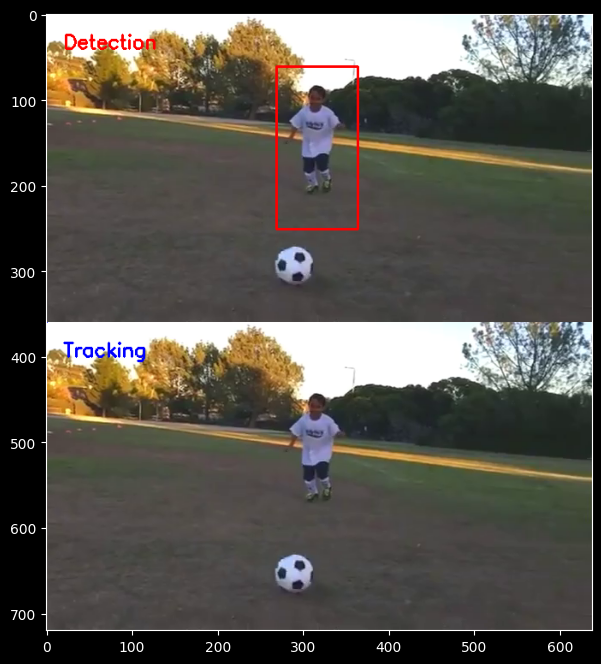

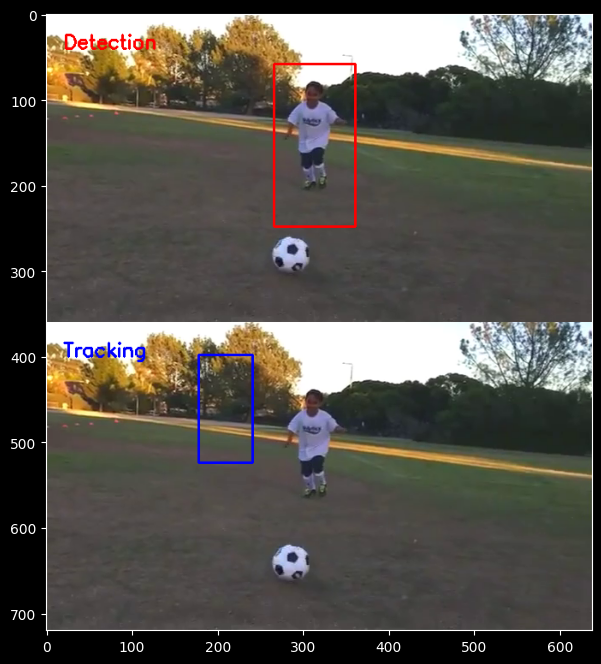

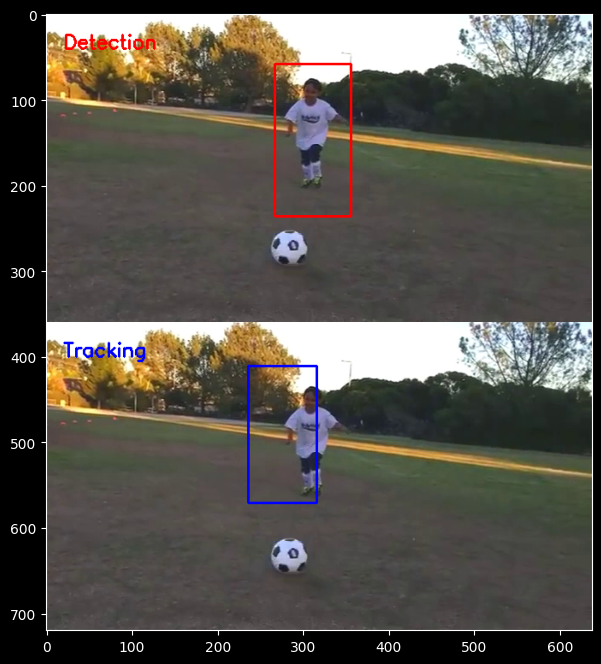

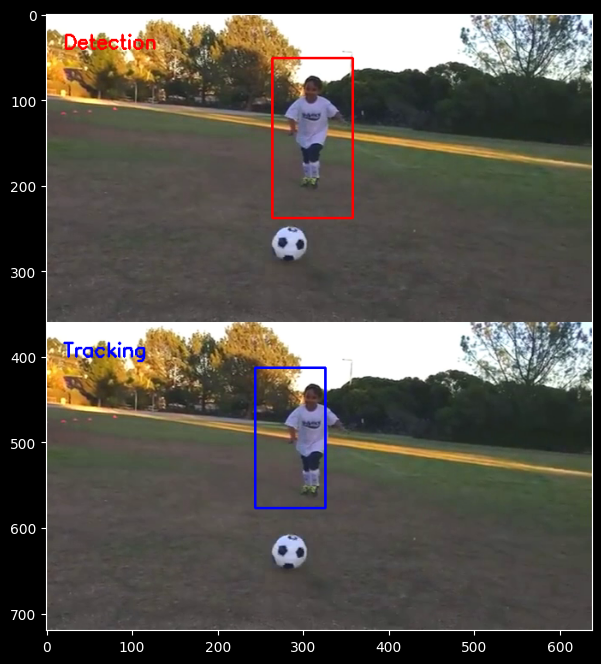

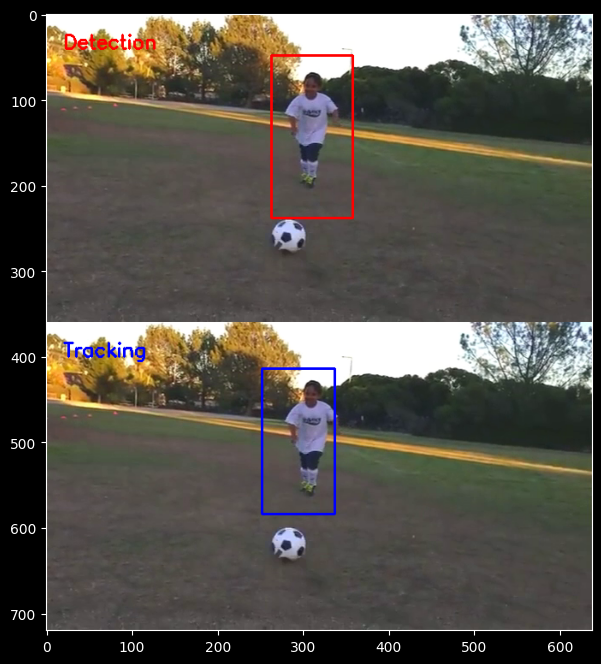

In [158]:
# dt for Transition matrix
dt = 0.0
# Random number generator for randomly selecting frames for update
random.seed(42)

# Loop over rest of the frames
# We will display output for only first 5 frames
count = 0
while True:
    success, frame = cap.read()
    if not success:
        break

    # Variable for displaying tracking result
    frameDisplay = frame.copy()
    # Variable for displaying detection result
    frameDisplayDetection = frame.copy()

    # Update dt for transition matrix.
    # dt = time elapsed.
    preTicks = ticks;
    ticks = cv2.getTickCount()
    dt = (ticks - preTicks) / cv2.getTickFrequency()

    KF.transitionMatrix[0, 3] = dt
    KF.transitionMatrix[1, 4] = dt
    KF.transitionMatrix[2, 5] = dt

    predictedMeasurement = KF.predict()

    # Detect objects in current frame
    objects, weights = hog.detectMultiScale(frame, winStride=(8, 8), padding=(3, 3),
                                            scale=1.05, hitThreshold=0, useMeanshiftGrouping=False)

    if len(objects) > 0:
        # Find largest object
        objectDetected = maxRectArea(objects)

        # Display detected rectangle
        x1, y1, w1, h1 = objectDetected.ravel()
        cv2.rectangle(frameDisplayDetection, (x1, y1), (x1+w1, y1+h1), red, 2, 4)

    # We will update measurements 15% of the time.
    # Frames are randomly chosen.
    update = random.randint(0, 100) < 15

    if update:
        # Kalman filter update step
        if len(objects) > 0:
            # Copy x, y, w from the detected rectangle
            measurement = objectDetected[0:3].astype(np.float32)

            # Perform Kalman update step
            updatedMeasurement = KF.correct(measurement)
            measurementWasUpdated = True
        else:
            # Measurement not updated because no object detected
            measurementWasUpdated = False
    else:
        # Measurement not updated
        measurementWasUpdated = False

    if measurementWasUpdated:
        # Use updated measurement if measurement was updated
        objectTracked[0:3, 0] = updatedMeasurement[0:3, 0].astype(np.int32)
        objectTracked[3, 0] = 2*updatedMeasurement[2, 0].astype(np.int32)
    else:
        # If measurement was not updated, use predicted values.
        objectTracked[0:3, 0] = predictedMeasurement[0:3, 0].astype(np.int32)
        objectTracked[3, 0] = 2*predictedMeasurement[2, 0].astype(np.int32)

    # Draw tracked object
    x2, y2, w2, h2 = map(int, objectTracked.ravel())
    cv2.rectangle(frameDisplay, (x2, y2), (x2+w2, y2+h2), blue, 2, 4)

    # Text indicating Tracking or Detection.
    cv2.putText(frameDisplay, "Tracking", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.75, blue, 2)
    cv2.putText(frameDisplayDetection, "Detection", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.75, red, 2)

    # Concatenate detected result and tracked result vertically
    output = np.concatenate((frameDisplayDetection, frameDisplay), axis=0)

    # Display result.
    plt.imshow(output[:,:,::-1])
    plt.show()
    count += 1
    if count == 5:
        break

https://medium.com/self-driving-cars/all-about-kalman-filters-8924abe3aa88

https://www.researchgate.net/publication/224138621_Applications_of_Kalman_Filtering_in_Aerospace_1960_to_the_Present_Historical_Perspectives

http://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/
